In [1]:
import pandas as pd
import pandas_datareader as data
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
start_date = '1928-01-01'
end_date = '2022-08-01'
MAX_YEARS = 40
TAX = 0.2
INIT_AMOUNT = 0
MAX_AMOUNT = 20000000
step = 100000
monthly_min = 3000
monthly_max = 15000
monthly_step = 1000
min_amount_tolerable = 100000
INFLATION_ON = True
dump_data = True
data_source = 'yahoo'
default_model = 'S&P500'
MODELS = {'S&P500':'^GSPC','NASDAQ':'^IXIC','DOW':'^DJI','Tres10y':'^TNX','Coke':'KO','GE':'GE','IBM':'IBM'}

result_df = pd.DataFrame(columns = ['start_date','principle','monthly','months_survive','survive'])

In [3]:
#validate code
#data.DataReader('nasdaq', data_source, start_date, end_date)[['Close']]

In [4]:
def prep_data(source=MODELS[default_model], inflation=INFLATION_ON ):
    print('prep started')
    # pull raw data
    stock = data.DataReader(source, data_source, start_date, end_date)[['Close']]
    #pull the earliest stock date available
    new_start = stock.index[0]
    cpi = data.DataReader("CPIAUCNS", "fred", new_start, end_date)
    
    # user merger and then fill in monthly from the previous close if possible else the next close
    df = cpi.merge(stock, how='outer', left_index=True, right_index=True)
    df[['Close']] = df[['Close']].fillna(method='ffill').fillna(method='bfill')

    # remove non first month 
    df.dropna(inplace=True)

    # set placeholders
    df['inflation'] = 0.0
    df['change'] = 0.0
    df.reset_index(inplace=True)

    # calculate baseline df
    for i in range(len(df)):
        # skip the first iteration
        if i == 0: continue
        # update inflation
        if inflation:
            p_cpi = df.at[i-1,'CPIAUCNS']
            c_cpi = df.at[i,'CPIAUCNS']
            df.at[i,'inflation']= (c_cpi - p_cpi)/p_cpi
        # update percent change
        p_close = df.at[i-1,'Close']
        c_close = df.at[i,'Close']
        df.at[i,'change'] = (c_close - p_close)/p_close
    print('prep done')
    return df

In [5]:
def model_year(prin, start_date_index, withdrawal, min_amount_tol, df, tax=TAX, years=MAX_YEARS):
    global result_df
    # calculates the model year and inserts into results df
    # returns boolean for making it to the end of the year
    failed = False
    s_date = df.at[start_date_index,'index'].strftime('%Y_%m_%d')
    mnth = f'monthly_{s_date}_{prin}_{withdrawal}'
    prcp = f'principle_{s_date}_{prin}_{withdrawal}'
    df[mnth] = np.nan
    df[prcp] = np.nan
    k=0
    end = start_date_index + years*12 +1
    start = df.at[start_date_index,'index']
    for i in range(start_date_index,end):
        if k==0:
            df.at[i,mnth]= withdrawal
            df.at[i,prcp]= prin
            k+=1
            continue
        if i > len(df):
            break
        p = i-1
        # previous monthly * (1+inflation)
        p_m = df.at[p,mnth]
        c_i = df.at[i,'inflation']
        c_m = p_m*(1+c_i)
        df.at[i,mnth]= c_m
        # (previous principle*(1+change)) - current monthly
        p_p = df.at[p,prcp]
        p_c = df.at[p,'Close']
        c_c = df.at[i,'Close']
        change =  (c_c-p_c)/p_c
        c_p = p_p*(1+change)-(c_m/(1-tax))
        df.at[i,prcp]= c_p
        failed = (c_p <= min_amount_tol)
        if failed or i == end-1:
            res = pd.DataFrame.from_dict({'start_date': [start], 'principle': prin, 'monthly': withdrawal,'months_survive': [i-start_date_index], 'survive': [not failed]})
            result_df = pd.concat([result_df,res], ignore_index=True)
            break
    if dump_data:
        df.drop(columns=[mnth,prcp], inplace=True)
    return failed
    

In [6]:
# Testing
# model_year(init_amount, 0, 8000, df)
# result_df.head()

In [7]:
def seek_year(sdi, p_min, p_max, step, withdrawal, min_amount_tol, baseline_df, tax=TAX, years=MAX_YEARS):
    # sdi = start date index 
    # p_min = principle min
    # p_max = principle max
    # step = increase step from in to max
    
    # presumes failed state
    failed = True
    for prin in range(p_min,p_max,step):
        failed = model_year(prin, sdi, withdrawal, min_amount_tol, baseline_df, tax, years)
        # exists when succeeds
        if not failed:
            break

In [8]:
# Testing
# seek_year(0, init_amount, max_amount, step, monthly,df)
# result_df.head()

In [9]:
def run_model(model = MODELS['S&P500'], years=MAX_YEARS,
              min_amount_tol=min_amount_tolerable, tax=TAX,
              monthly_min= monthly_min, monthly_max=monthly_max, inflation= INFLATION_ON):
    model_df = prep_data(model)
    lsi = int((len(model_df)- years*12)/12)
    for s in range(lsi + 1):
        s_date_i = s*12
        year = model_df.at[s_date_i,'index'].strftime('%Y_%m_%d')
        print(f'analyzing year: {year} {s+1} of {lsi + 1}')
        for monthly in range(monthly_min,monthly_max+monthly_step,monthly_step):
            seek_year(s_date_i, INIT_AMOUNT, MAX_AMOUNT, step, monthly, min_amount_tol, model_df,tax, years)

In [10]:
def only_survived():
    survive_df = result_df[result_df.survive]
    survive_df= survive_df.astype({'start_date': object, 
                                   'principle': int, 
                                   'monthly': int, 
                                   'months_survive': int, 
                                   'survive': bool})
    return survive_df

In [11]:
%%time
run_model()
sdf = only_survived()

prep started
prep done
analyzing year: 1928_02_01 1 of 55
analyzing year: 1929_02_01 2 of 55
analyzing year: 1930_02_01 3 of 55
analyzing year: 1931_02_01 4 of 55
analyzing year: 1932_02_01 5 of 55
analyzing year: 1933_02_01 6 of 55
analyzing year: 1934_02_01 7 of 55
analyzing year: 1935_02_01 8 of 55
analyzing year: 1936_02_01 9 of 55
analyzing year: 1937_02_01 10 of 55
analyzing year: 1938_02_01 11 of 55
analyzing year: 1939_02_01 12 of 55
analyzing year: 1940_02_01 13 of 55
analyzing year: 1941_02_01 14 of 55
analyzing year: 1942_02_01 15 of 55
analyzing year: 1943_02_01 16 of 55
analyzing year: 1944_02_01 17 of 55
analyzing year: 1945_02_01 18 of 55
analyzing year: 1946_02_01 19 of 55
analyzing year: 1947_02_01 20 of 55
analyzing year: 1948_02_01 21 of 55
analyzing year: 1949_02_01 22 of 55
analyzing year: 1950_02_01 23 of 55
analyzing year: 1951_02_01 24 of 55
analyzing year: 1952_02_01 25 of 55
analyzing year: 1953_02_01 26 of 55
analyzing year: 1954_02_01 27 of 55
analyzing year

In [83]:
sdf

,start_date,principle,monthly,months_survive,survive
19,1928-02-01 00:00:00,1900000,3000,480,True
46,1928-02-01 00:00:00,2600000,4000,480,True
79,1928-02-01 00:00:00,3200000,5000,480,True
118,1928-02-01 00:00:00,3800000,6000,480,True
163,1928-02-01 00:00:00,4400000,7000,480,True
...,...,...,...,...,...
29687,1982-02-01 00:00:00,2100000,11000,480,True
29711,1982-02-01 00:00:00,2300000,12000,480,True
29737,1982-02-01 00:00:00,2500000,13000,480,True
29765,1982-02-01 00:00:00,2700000,14000,480,True


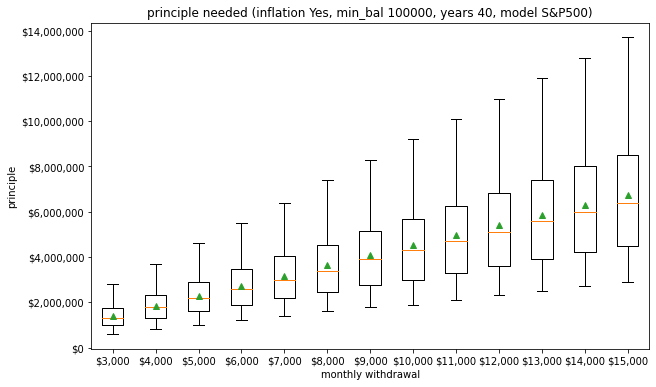

In [82]:
inf_text = 'Yes' if INFLATION_ON else 'No'
title = f'principle needed (inflation {inf_text}, min_bal {min_amount_tolerable}, years {MAX_YEARS}, model {default_model})'
x_l = 'monthly withdrawal'
y_l = 'principle'

unique_monthly = sdf.monthly.unique()
data =[list(sdf[sdf['monthly'] == i].principle) for i in unique_monthly]
fig, ax = plt.subplots()

fig.set_size_inches(10, 6)
ax.set_title(title)
ax.boxplot(data, showmeans=True)
ax.set_xticklabels(['${:,}'.format(x) for x in unique_monthly])
ax.yaxis.set_major_formatter('${x:,.0f}')
ax.set_ylabel(y_l)
ax.set_xlabel(x_l)

r

plt.show()


In [121]:
list(sdf.monthly.unique())

In [110]:
sdf2 = sdf[['principle','monthly']].groupby('monthly').describe()

